In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_context("paper")
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import linear_model

### Reading Data

In [2]:
crop_df0 = pd.read_csv("crop_production.csv")
crop_df0.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,720.0,165.0


In [3]:
crop_df = crop_df0.sample(n=50000, replace = False)
crop_df.to_csv('crop_df.csv',index=False)

In [4]:
crop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 178662 to 160743
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   State_Name     50000 non-null  object 
 1   District_Name  50000 non-null  object 
 2   Crop_Year      50000 non-null  int64  
 3   Season         50000 non-null  object 
 4   Crop           50000 non-null  object 
 5   Area           50000 non-null  float64
 6   Production     49238 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 3.1+ MB


In [5]:
crop_df.dropna(inplace=True)


In [6]:
crop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49238 entries, 178662 to 160743
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   State_Name     49238 non-null  object 
 1   District_Name  49238 non-null  object 
 2   Crop_Year      49238 non-null  int64  
 3   Season         49238 non-null  object 
 4   Crop           49238 non-null  object 
 5   Area           49238 non-null  float64
 6   Production     49238 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 3.0+ MB


In [7]:

# Calculate the IQR for the Production and Area columns
Q1_prod = crop_df['Production'].quantile(0.25)
Q3_prod = crop_df['Production'].quantile(0.75)
IQR_prod = Q3_prod - Q1_prod

Q1_area = crop_df['Area'].quantile(0.25)
Q3_area = crop_df['Area'].quantile(0.75)
IQR_area = Q3_area - Q1_area

# Identify outliers by setting a threshold for the IQR (e.g., 1.5 times the IQR)
threshold = 1.5
prod_outliers = crop_df[(crop_df['Production'] < Q1_prod - threshold*IQR_prod) | 
                     (crop_df['Production'] > Q3_prod + threshold*IQR_prod)]

area_outliers = crop_df[(crop_df['Area'] < Q1_area - threshold*IQR_area) | 
                     (crop_df['Area'] > Q3_area + threshold*IQR_area)]

# Print the outliers
print("Production outliers:\n", prod_outliers)
print("Area outliers:\n", area_outliers)


Production outliers:
            State_Name District_Name  Crop_Year       Season       Crop  \
137166    Maharashtra        WASHIM       1999  Kharif        Soyabean   
205867  Uttar Pradesh        BUDAUN       1998  Whole Year   Sugarcane   
172369      Rajasthan     JHUNJHUNU       2006  Kharif           Bajra   
158278         Odisha          PURI       2004  Winter            Rice   
206930  Uttar Pradesh     CHANDAULI       2002  Rabi             Wheat   
...               ...           ...        ...          ...        ...   
166267      Rajasthan        BARMER       2004  Rabi             Wheat   
60475         Gujarat      JUNAGADH       1998  Whole Year      Garlic   
239666    West Bengal    COOCHBEHAR       2012  Rabi             Wheat   
129953    Maharashtra       JALGAON       2008  Kharif       Sugarcane   
15191           Assam       DARRANG       2008  Whole Year   Sugarcane   

            Area  Production  
137166   76900.0    187900.0  
205867   23288.0   1504684.

In [8]:
area_outliers.count()

State_Name       8066
District_Name    8066
Crop_Year        8066
Season           8066
Crop             8066
Area             8066
Production       8066
dtype: int64

In [9]:
# Define the upper and lower bounds for outlier detection
upper_bound = Q3_area + 1.5 * IQR_prod
lower_bound = Q1_area - 1.5 * IQR_prod

# Drop the outliers
crop_df = crop_df[(crop_df[['Production', 'Area']] > lower_bound).all(axis=1) & (crop_df[['Production', 'Area']] < upper_bound).all(axis=1)]

In [10]:

# calculate the correlation matrix
corr_matrix = crop_df[['Production', 'Area']].corr()

# print the correlation matrix
print(corr_matrix)


            Production      Area
Production    1.000000  0.632598
Area          0.632598  1.000000


So the dataset has crop production details state-wise and then goes a level deep with district details. It has data from 1997-2014. Some other intersting features that are available to us are the crop season and area of the field. 

My approach here is going with the flow. I'm also going to back it up with some research information (along with links) to see if the data and analysis meet.

##### Note: This data is only about India. And so the scope of research is also going to be limited to just India.

Let's begin by looking at the state-wise production

### State-Wise Production - 1997-2014

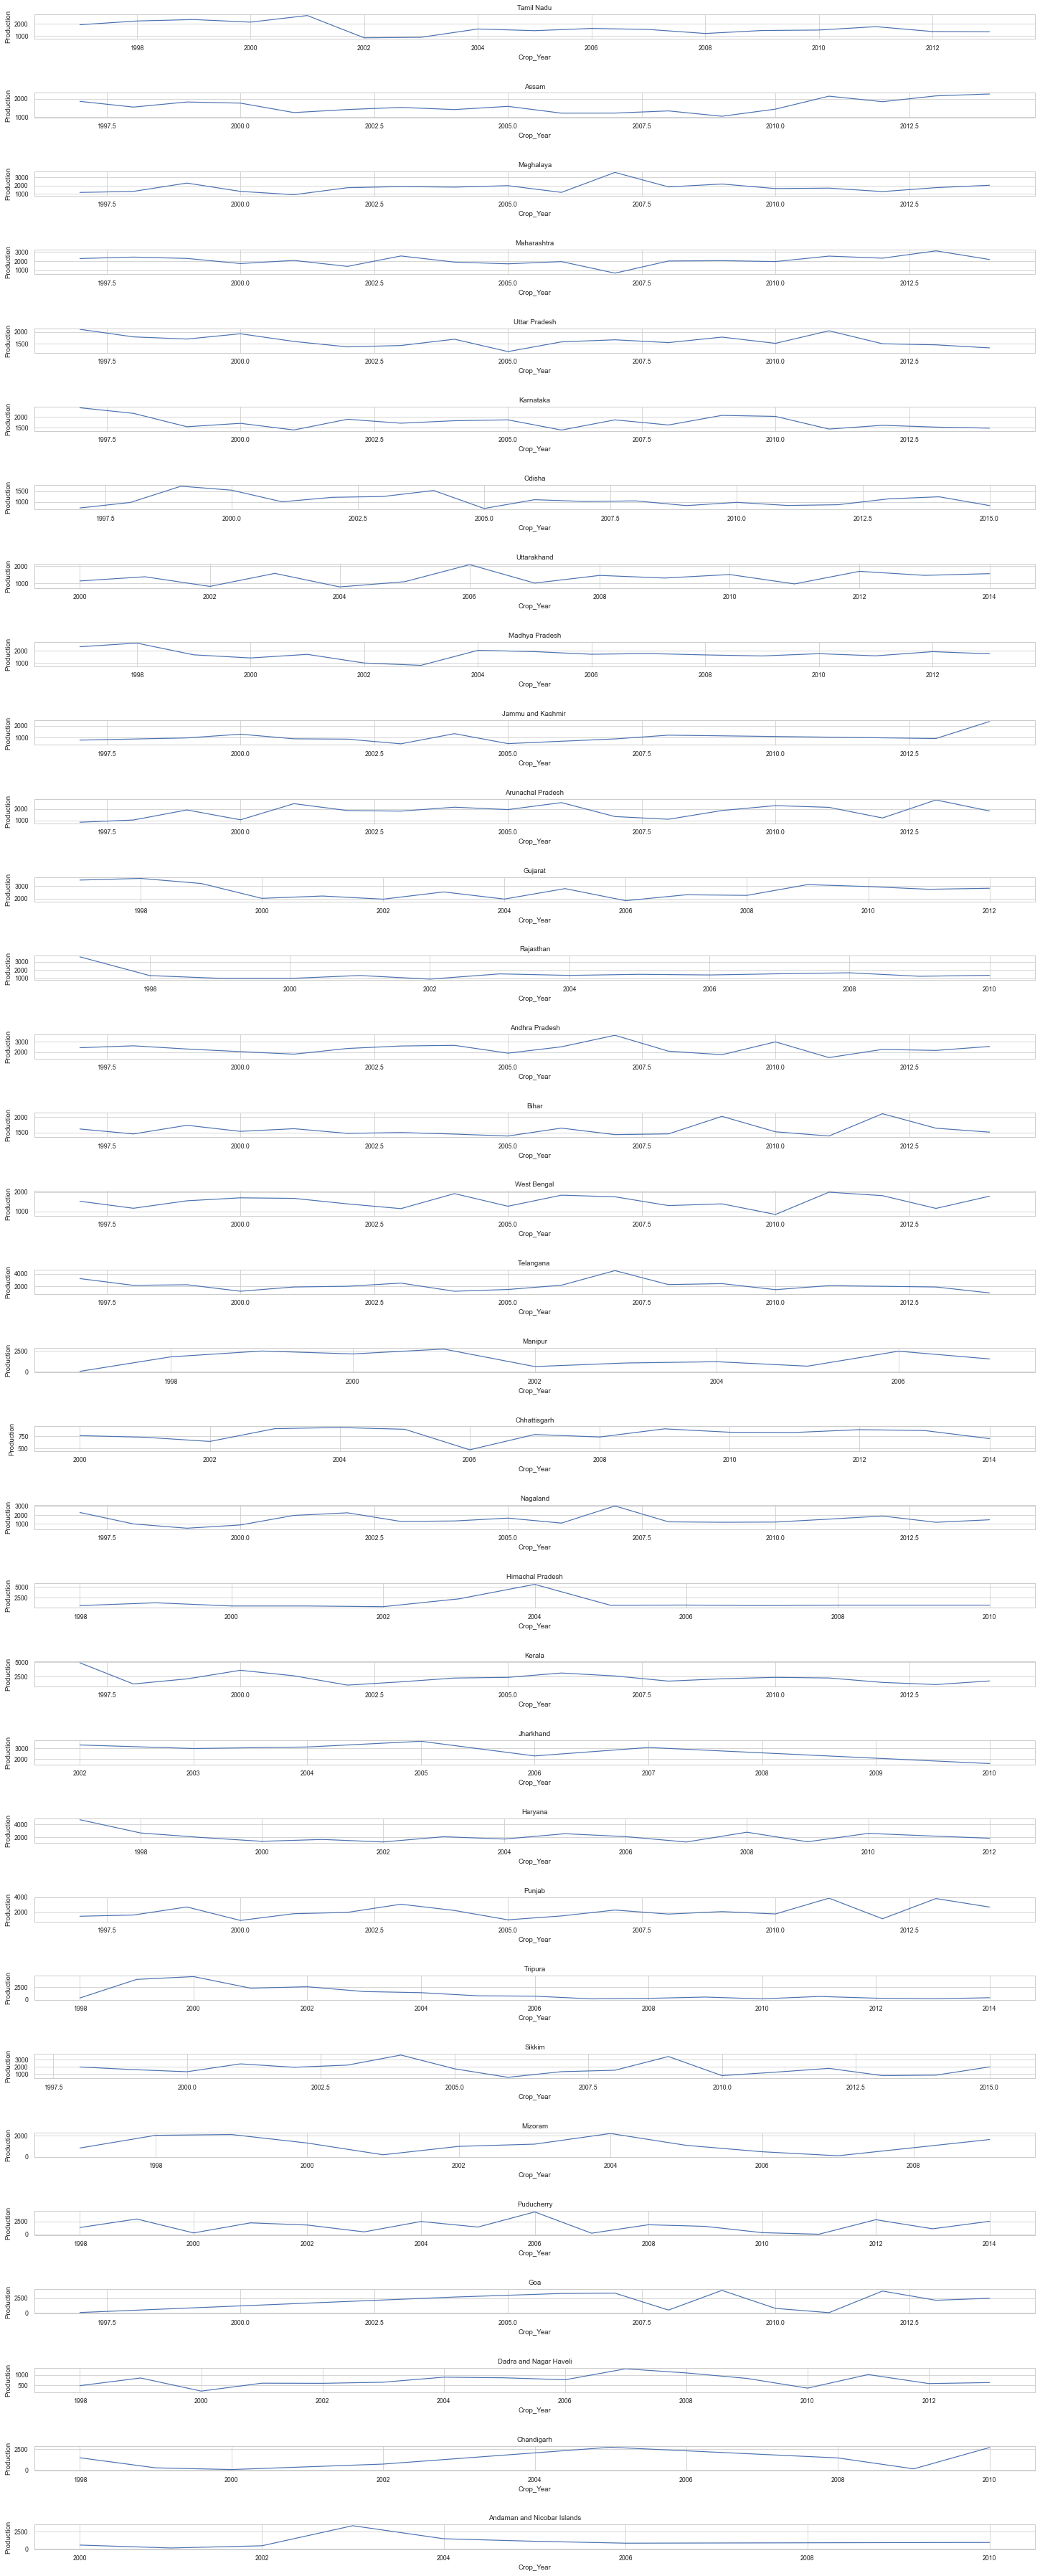

In [11]:
fig, ax = plt.subplots(figsize=(25,65), sharex='col')
count = 1

for state in crop_df.State_Name.unique():
    plt.subplot(len(crop_df.State_Name.unique()),1,count)
    sns.lineplot(crop_df[crop_df.State_Name==state]['Crop_Year'],crop_df[crop_df.State_Name==state]['Production'], ci=None)
    plt.subplots_adjust(hspace=2.2)
    plt.title(state)
    count+=1

Though informative and granular, to see patterns, we'll need to aggregate data. 

Let's get the zonal details to see if we can see any pattern. Using https://www.mapsofindia.com/zonal/ the states are divided into Zones. 

### Zone-Wise Production - 1997-2014

In [12]:
north_india = ['Jammu and Kashmir', 'Punjab', 'Himachal Pradesh', 'Haryana', 'Uttarakhand', 'Uttar Pradesh', 'Chandigarh']
east_india = ['Bihar', 'Odisha', 'Jharkhand', 'West Bengal']
south_india = ['Andhra Pradesh', 'Karnataka', 'Kerala' ,'Tamil Nadu', 'Telangana']
west_india = ['Rajasthan' , 'Gujarat', 'Goa','Maharashtra','Goa']
central_india = ['Madhya Pradesh', 'Chhattisgarh']
north_east_india = ['Assam', 'Sikkim', 'Nagaland', 'Meghalaya', 'Manipur', 'Mizoram', 'Tripura', 'Arunachal Pradesh']
ut_india = ['Andaman and Nicobar Islands', 'Dadra and Nagar Haveli', 'Puducherry']

In [13]:
def get_zonal_names(row):
    if row['State_Name'].strip() in north_india:
        val = 'North Zone'
    elif row['State_Name'].strip()  in south_india:
        val = 'South Zone'
    elif row['State_Name'].strip()  in east_india:
        val = 'East Zone'
    elif row['State_Name'].strip()  in west_india:
        val = 'West Zone'
    elif row['State_Name'].strip()  in central_india:
        val = 'Central Zone'
    elif row['State_Name'].strip()  in north_east_india:
        val = 'NE Zone'
    elif row['State_Name'].strip()  in ut_india:
        val = 'Union Terr'
    else:
        val = 'No Value'
    return val

crop_df['Zones'] = crop_df.apply(get_zonal_names, axis=1)
crop_df['Zones'].unique()

array(['South Zone', 'NE Zone', 'West Zone', 'North Zone', 'East Zone',
       'Central Zone', 'Union Terr'], dtype=object)

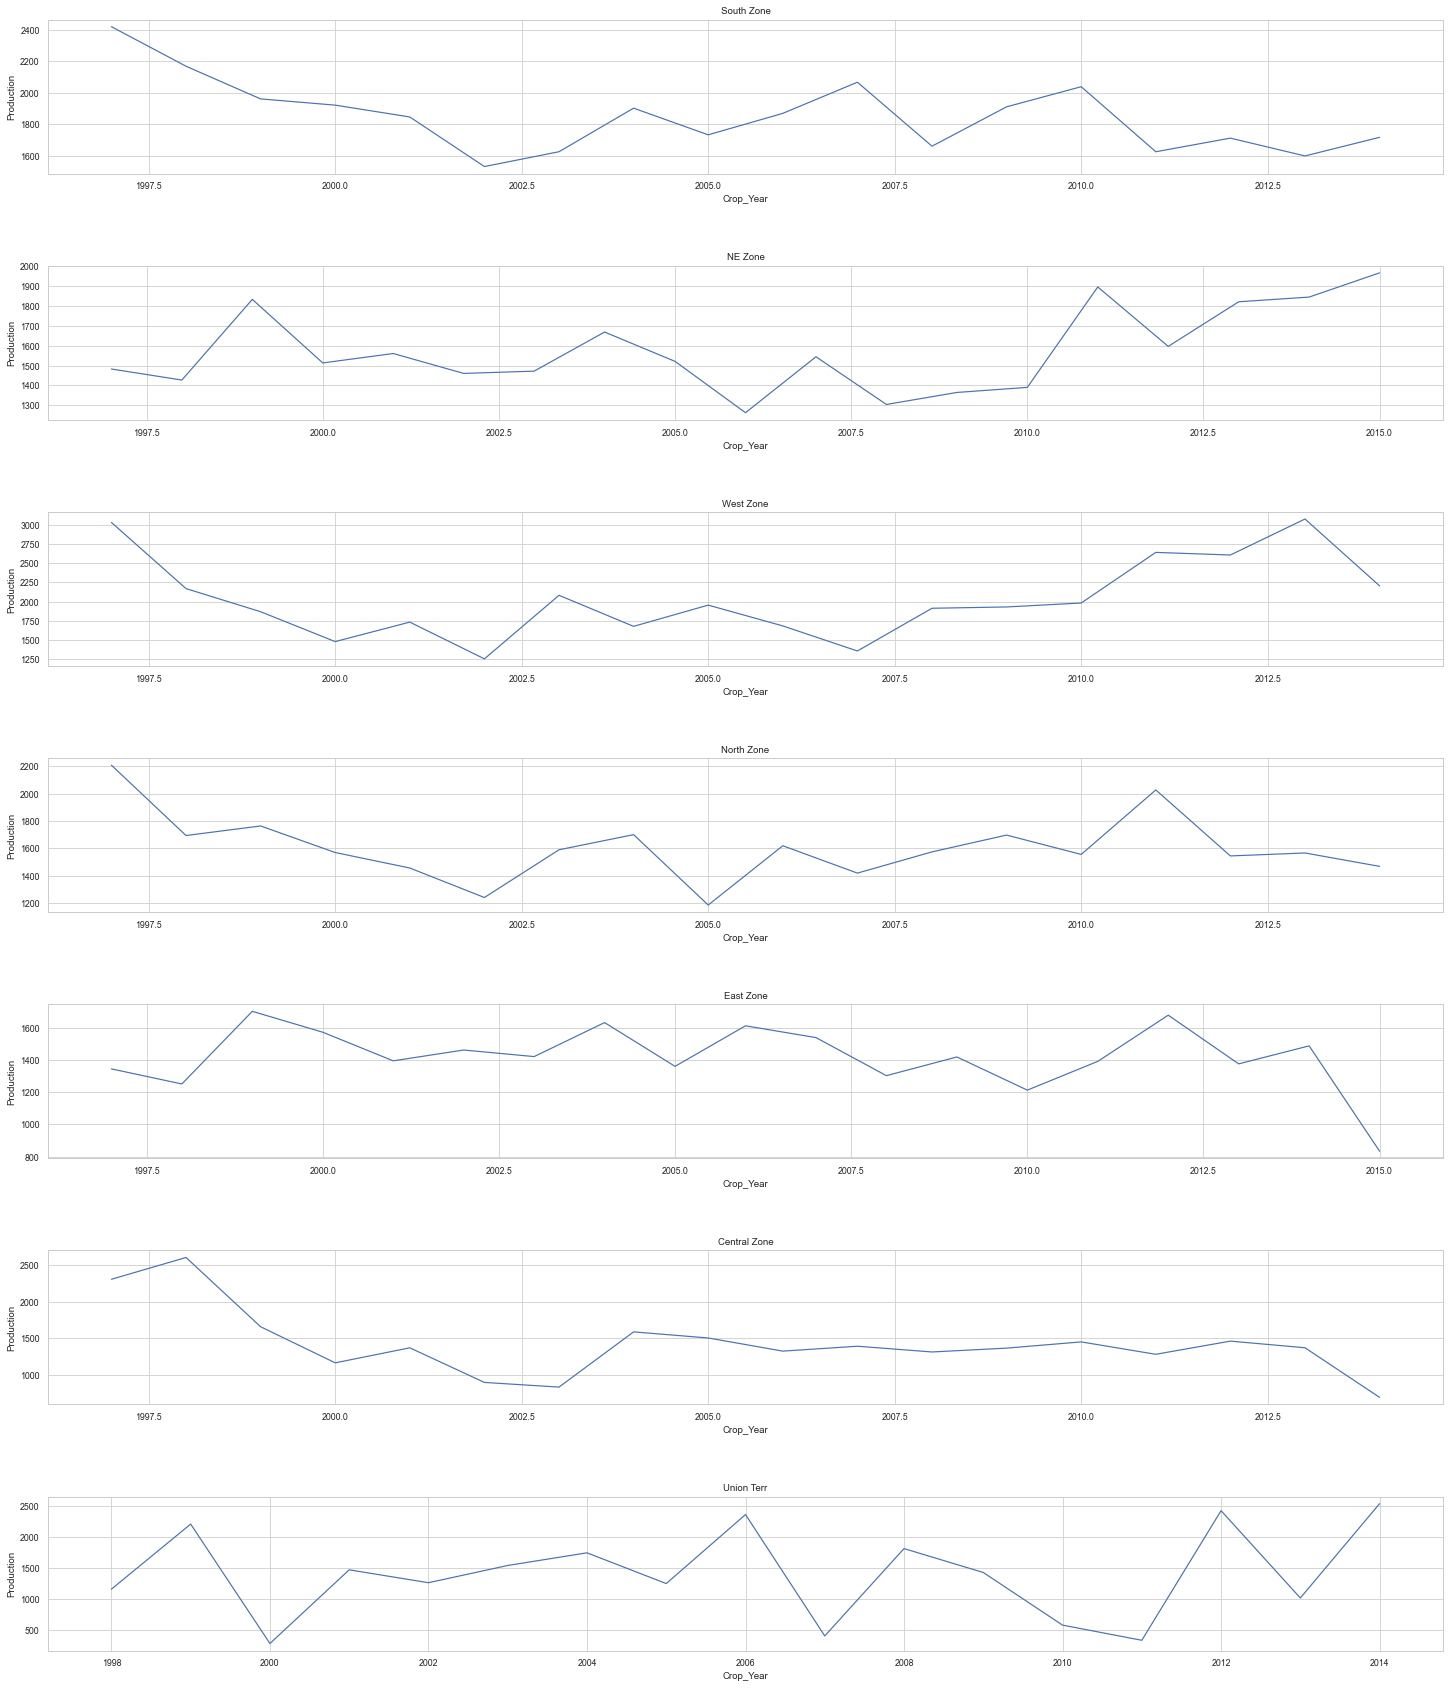

In [14]:
fig, ax = plt.subplots(figsize=(25,30), sharex='col')
count = 1

for zone in crop_df.Zones.unique():
    plt.subplot(len(crop_df.Zones.unique()),1,count)
    sns.lineplot(crop_df[crop_df.Zones==zone]['Crop_Year'],crop_df[crop_df.Zones==zone]['Production'], ci=None)
    plt.subplots_adjust(hspace=0.6)
    plt.title(zone)
    count+=1

### Zone-Wise Production - Total

In [15]:
zone_df = crop_df.groupby(by='Zones')['Production'].sum().reset_index().sort_values(by='Production', ascending=False)
zone_df.head()

,Zones,Production
4,South Zone,14905810.97
3,North Zone,12772805.50
1,East Zone,10519554.74
6,West Zone,9006735.88
2,NE Zone,7849513.22


Text(0.5, 1.0, 'Zone-Wise Production: Total')

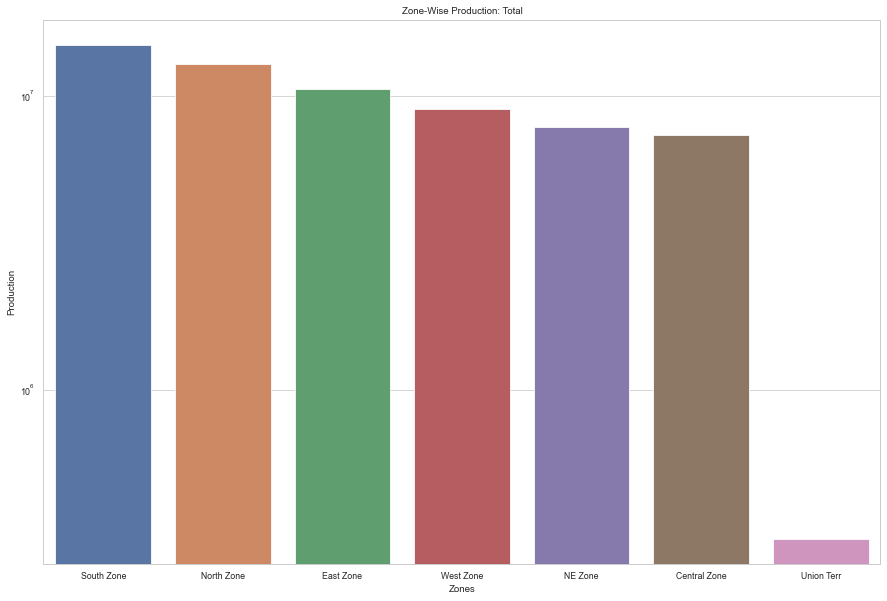

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(zone_df.Zones, zone_df.Production)
plt.yscale('log')
plt.title('Zone-Wise Production: Total')

Clearly the South Zone leads in terms of overall production. Lets delve into the southern zone and get more details.

### South Zone Production

,State_Name,Production
1,Karnataka,5943820.23
0,Andhra Pradesh,3138338.00
3,Tamil Nadu,3117769.05
4,Telangana,1567718.00
2,Kerala,1138165.69


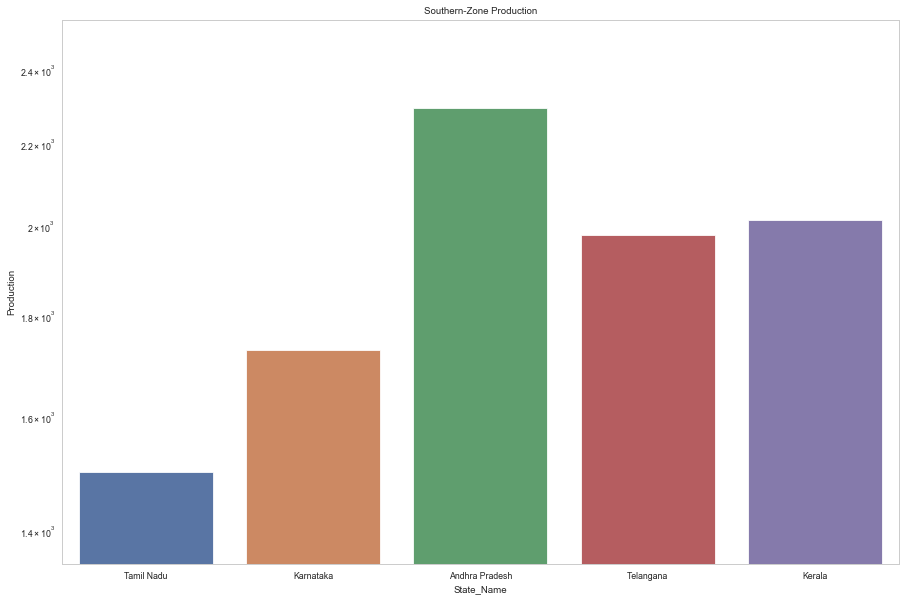

In [17]:
south_zone =  crop_df[(crop_df["Zones"] == 'South Zone')]
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(south_zone.State_Name, south_zone.Production,errwidth=0)
plt.yscale('log')
plt.title('Southern-Zone Production')

south_zone.groupby(by='State_Name')['Production'].sum().reset_index().sort_values(by='Production', ascending=False)

Kerala leads the production in southern zone by a huge margin. This is interesting! Let's see what makes Kerala have such a huge margin when it comes to crop production. What crop is it? No brownie points for guessing! 

### South Zone - Highest Produced Crops

Text(0.5, 1.0, 'South Zone Crops vs Production')

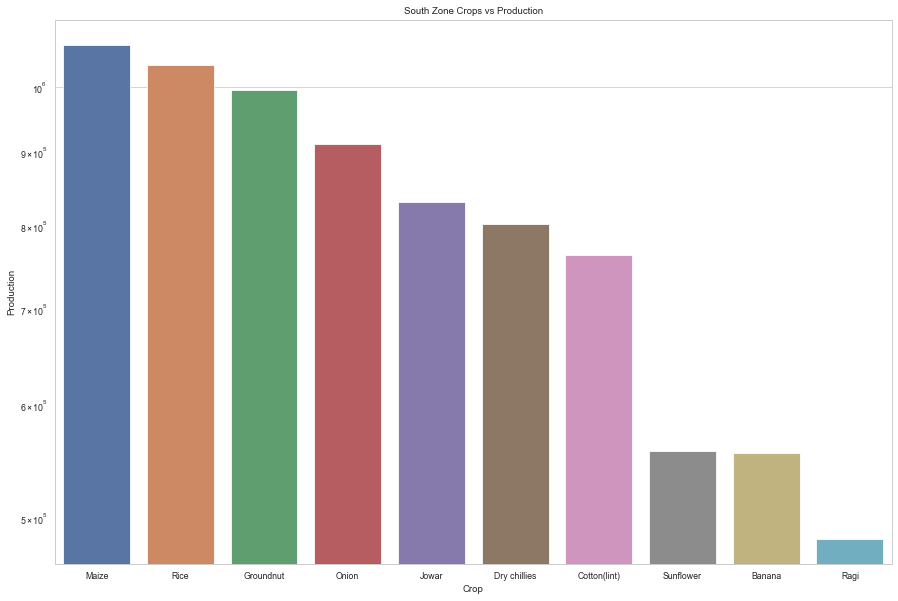

In [18]:
df = south_zone.groupby(by='Crop')['Production'].sum().reset_index().sort_values(by='Production', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(df.Crop, df.Production,errwidth=0)
plt.yscale('log')
plt.title('South Zone Crops vs Production')

##### **Coconut** 

So, now what all do I know? That South leads total production. And Kerala dominates in South Zone with its major contribution being Coconuts. Roughly looking at this, I would like to think that Coconut dominates all the crops in terms of production but let's just be sure about this.

### Overall Crop Production

Text(0.5, 1.0, 'Overall Crops vs Production')

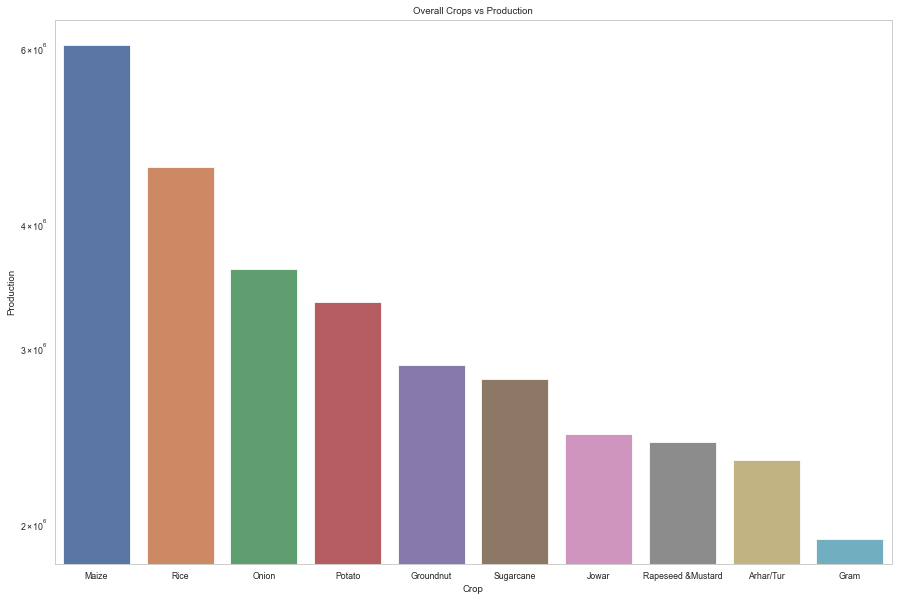

In [19]:
crop = crop_df.groupby(by='Crop')['Production'].sum().reset_index().sort_values(by='Production', ascending=False).head(10)
crop 
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(crop.Crop, crop.Production,errwidth=0)
plt.yscale('log')
plt.title('Overall Crops vs Production')

I wasn't wrong about eh?.

The numbers spoke for crops. Also, Coconut can be harvested year long depending on its use. More here http://vikaspedia.in/agriculture/crop-production/package-of-practices/plantation-crops/coconut/coconut-cultivation-practices

But look at the other values. I see something fishy. If I remember correctly, Sugarcane, Rice, Maize are Kharif crops. Hmm... 
Let's check this...

In [20]:
set(crop_df[(crop_df['Season'] == 'Whole Year ')].Crop.unique()) & set(crop_df[(crop_df['Season'] == 'Kharif     ')].Crop.unique()) 

{'Arecanut',
 'Arhar/Tur',
 'Bajra',
 'Banana',
 'Barley',
 'Black pepper',
 'Brinjal',
 'Cabbage',
 'Cardamom',
 'Cashewnut',
 'Castor seed',
 'Coconut ',
 'Coriander',
 'Cotton(lint)',
 'Dry chillies',
 'Dry ginger',
 'Garlic',
 'Ginger',
 'Gram',
 'Grapes',
 'Groundnut',
 'Guar seed',
 'Horse-gram',
 'Jowar',
 'Jute & mesta',
 'Linseed',
 'Maize',
 'Mango',
 'Masoor',
 'Mesta',
 'Moong(Green Gram)',
 'Moth',
 'Niger seed',
 'Oilseeds total',
 'Onion',
 'Orange',
 'Papaya',
 'Peas & beans (Pulses)',
 'Pome Granet',
 'Potato',
 'Pulses total',
 'Ragi',
 'Rapeseed &Mustard',
 'Rice',
 'Safflower',
 'Sannhamp',
 'Sesamum',
 'Small millets',
 'Soyabean',
 'Sugarcane',
 'Sunflower',
 'Sweet potato',
 'Tapioca',
 'Tobacco',
 'Tomato',
 'Turmeric',
 'Urad',
 'Wheat',
 'other oilseeds'}

So, we have some fishy data here. I am going to clean this so that I can classify some of the most important crops into the either Kharif or Rabi, and remaining clubbed as 'Others'

Ref: http://www.arthapedia.in/index.php%3Ftitle%3DCropping_seasons_of_India-_Kharif_%2526_Rabi


In [21]:
Kharif = ['Bajra','Jowar','Maize','Millet','Rice','Soybean','Fruits','Muskmelon','Sugarcane','Watermelon','Orange','Arhar/Tur,'
'Urad','Cotton(lint)','Cowpea(Lobia)','Moong(Green Gram)','Guar seed','Moth','Tomato','Turmeric', 'Ragi']
Rabi = ['Barley', 'Gram', 'Rapeseed &Mustard', 'Masoor', 'Coriander', 'Sunflower', 'Tobacco', 'Brinjal', 'Cabbage',
       'Onion','Sweet potato','Potato','Peas & beans (Pulses)', 'Oilseeds total', 'other oilseeds', 'Banana', 'Groundnut', 'Niger seed',
       'Sesamum','Safflower', 'Castor seed', 'Linseed', 'Soyabean']

def change_crop_seasons(row):
    if row['Crop'].strip() in Kharif:
        val = 'Kharif'
    elif row['Crop'].strip()  in Rabi:
        val = 'Rabi'
    else:
        val = 'Others'
    return val

crop_df['Updated_Crop_Season'] = crop_df.apply(change_crop_seasons, axis=1)
crop_df['Updated_Crop_Season'].unique()

array(['Others', 'Rabi', 'Kharif'], dtype=object)

Using the new column, let's explore the some more..


### Season vs Production

Note: Class Imbalance Warning!

Text(0.5, 1.0, 'Seasonal Crops vs Production')

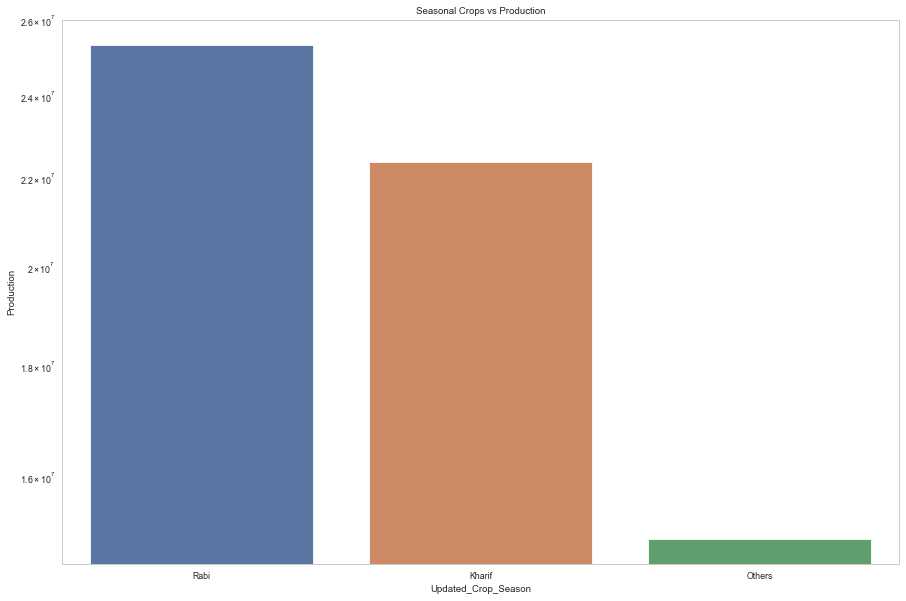

In [22]:
season = crop_df.groupby(by='Updated_Crop_Season')['Production'].sum().reset_index().sort_values(by='Production', ascending=False).head(10)
season
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(season.Updated_Crop_Season, season.Production,errwidth=0)
plt.yscale('log')
plt.title('Seasonal Crops vs Production')

Since The Indian cropping season is classified into two main seasons-(i) Kharif and (ii) Rabi based on the monsoon, Let's look at them..

### (i) Kharif

Let's look at the top ten most produced Kharif crops.

Text(0.5, 1.0, 'Kharif Crops Production')

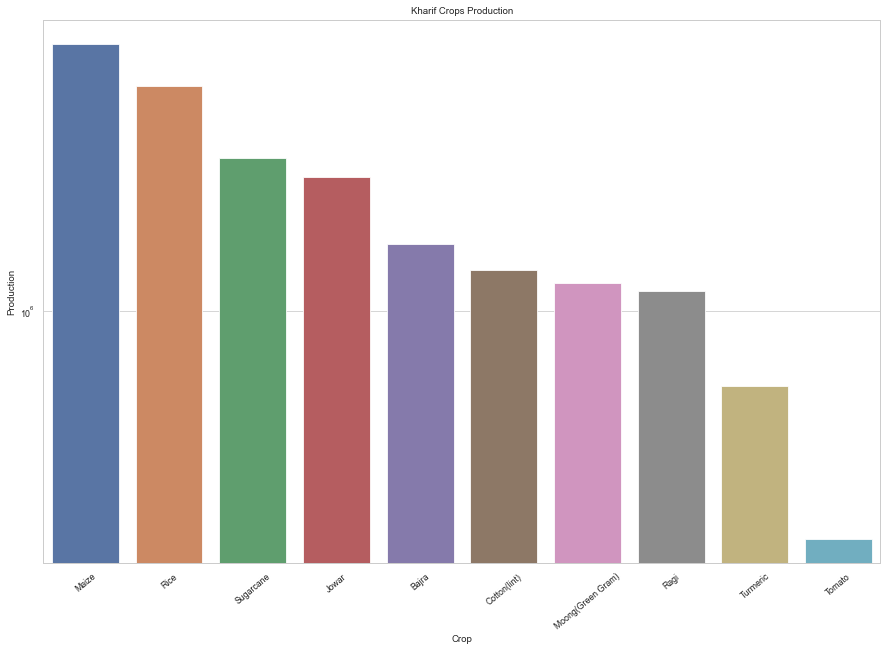

In [23]:
kharif_df = crop_df[(crop_df['Updated_Crop_Season'] == 'Kharif')]
df = kharif_df.groupby(by='Crop')['Production'].sum().reset_index().sort_values(by='Production', ascending=False).head(10)
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(df.Crop, df.Production,errwidth=0)
plt.yscale('log')
plt.xticks(rotation=40)
plt.title('Kharif Crops Production')

Sugarcane, Rice and Cotton lead in terms of Kharif crop production. Let's look at the zonal distribution for Sugarcane

Text(0.5, 1.0, 'Sugarcane Zone-Wise Production')

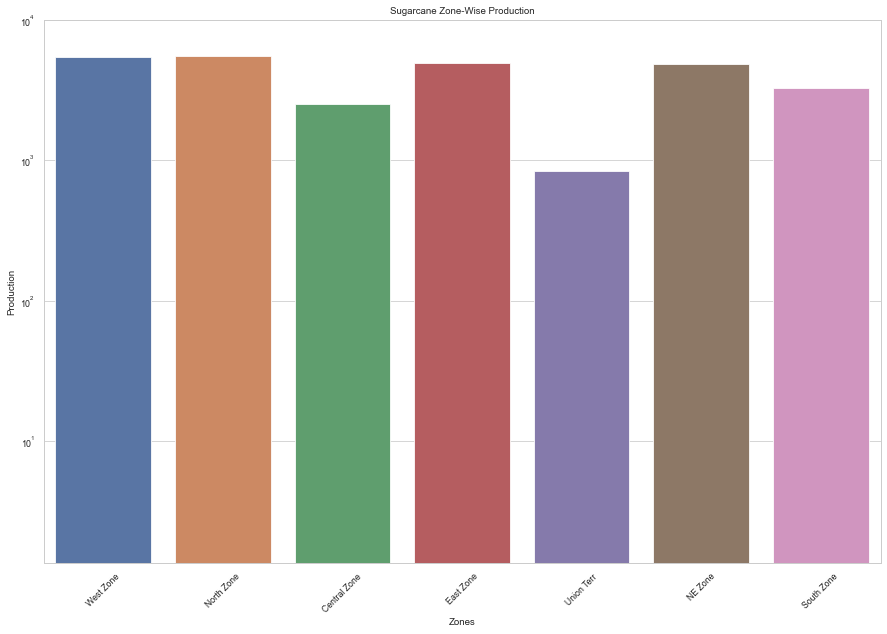

In [24]:
sugarcane_df = kharif_df[(kharif_df['Crop'] == 'Sugarcane')]
sugarcane_df.head()

fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(sugarcane_df.Zones, sugarcane_df.Production,errwidth=0)
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Sugarcane Zone-Wise Production')

This completely makes sense because this finding is confirmed with the link - https://farmer.gov.in/cropstaticssugarcane.aspx.
Here's another link talking about Sugarcane cultivation. 
https://www.mapsofindia.com/answers/india/state-biggest-sugarcane-producer/
Let's see if our data reflects the same.

Text(0.5, 1.0, 'Sugarcane State-Wise Production')

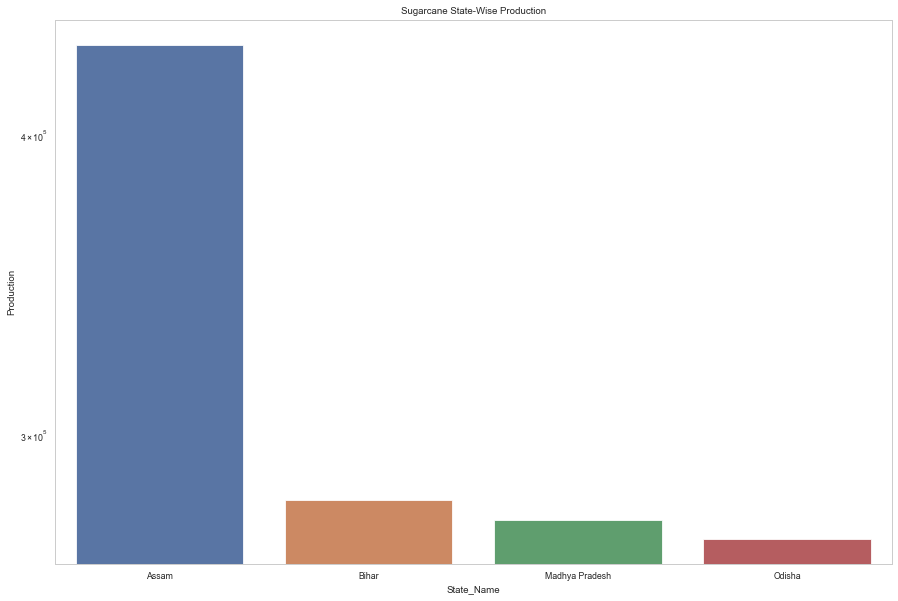

In [25]:
df = sugarcane_df.groupby(by='State_Name')['Production'].sum().reset_index().sort_values(by='Production', ascending=False)
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(df.State_Name.head(4), df.Production.head(4),errwidth=0)
plt.yscale('log')
plt.title('Sugarcane State-Wise Production')

Very cool! Let's go a step deeper now. Since Uttar Pradesh leads in this, lets look at the agricultural area distribution. 

,District_Name,Crop,Area
6,LALITPUR,Sugarcane,1139.0
4,JHANSI,Sugarcane,1036.0
8,SONBHADRA,Sugarcane,765.0
3,FIROZABAD,Sugarcane,738.0
1,CHITRAKOOT,Sugarcane,716.0


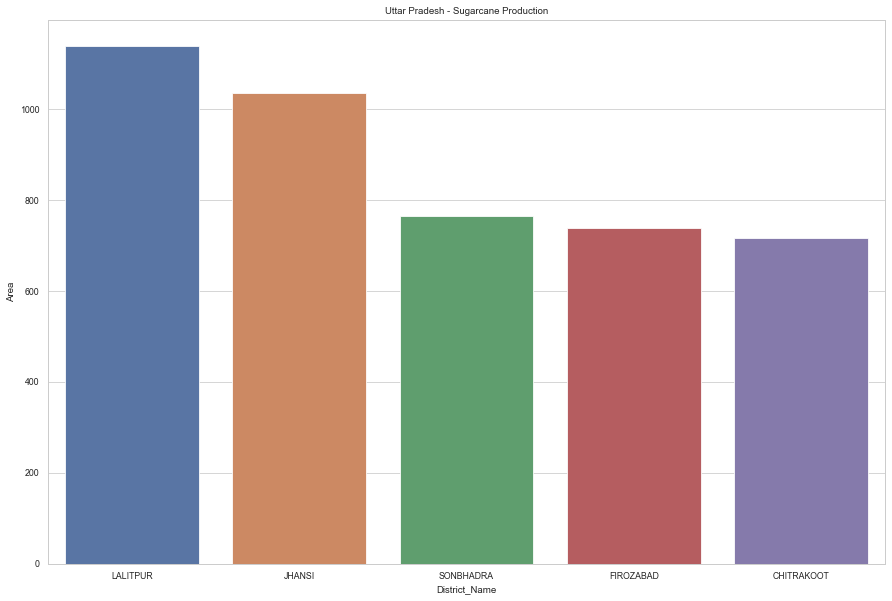

In [26]:
uttarpr_df = sugarcane_df[(sugarcane_df['State_Name'] == 'Uttar Pradesh')]
df = uttarpr_df.groupby(by=['District_Name', 'Crop'])['Area'].sum().reset_index().sort_values(by='Area', ascending=False)
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(df.District_Name.head(5), df.Area.head(5),errwidth=0)
plt.title('Uttar Pradesh - Sugarcane Production')
df.head(5)

The top 3 districts in Uttar Pradesh -  Kheri, Muzzaffnagar and Bijnor districts combined itself have a cultivation area of 11,640,115 units (1.1 crore units) only for Sugarcane. 

Let's repeat this for Rabi now. 

### (ii) Rabi

Text(0.5, 1.0, 'Rabi Crops Production')

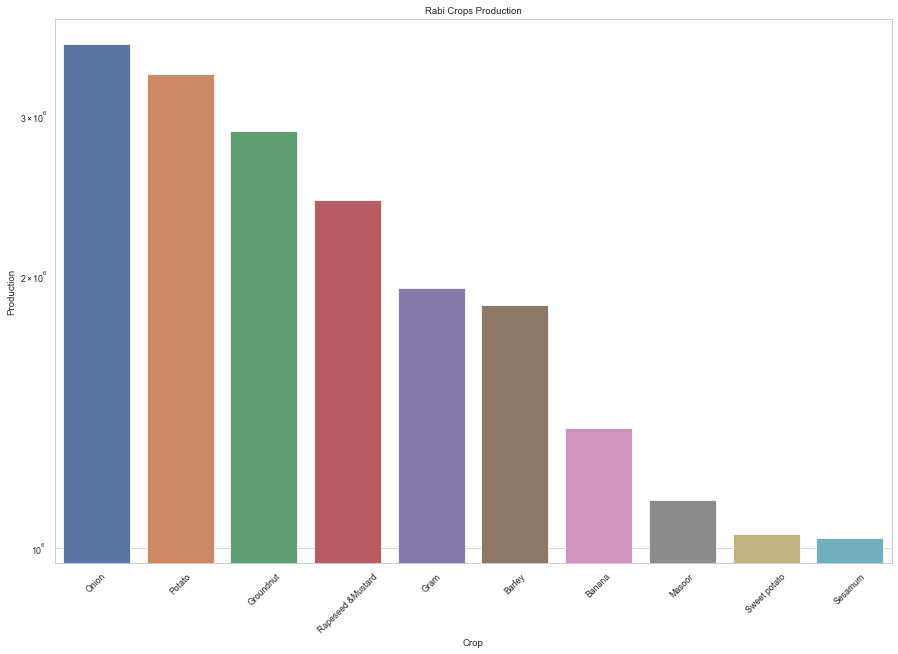

In [27]:
rabi_df = crop_df[(crop_df['Updated_Crop_Season'] == 'Rabi')]
df = rabi_df.groupby(by='Crop')['Production'].sum().reset_index().sort_values(by='Production', ascending=False).head(10)
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(df.Crop, df.Production,errwidth=0)
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Rabi Crops Production')

Potato, Banana and Soyabean lead in terms of Rabi crop production. Let's look at the zonal distribution.

Text(0.5, 1.0, 'Potato Zone-Wise Production')

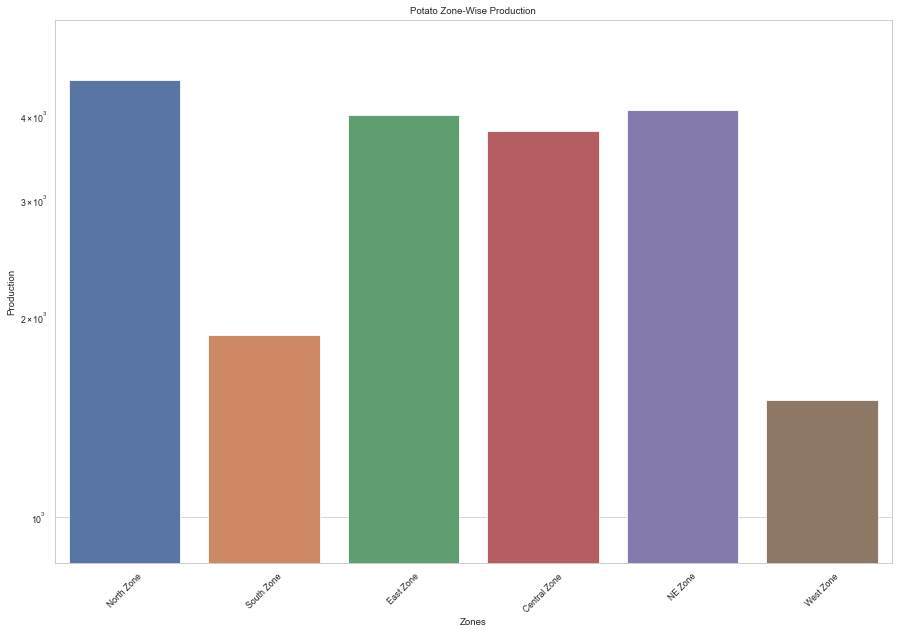

In [28]:
potato_df = rabi_df[(rabi_df['Crop'] == 'Potato')]
potato_df.head()

fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(potato_df.Zones, potato_df.Production,errwidth=0)
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Potato Zone-Wise Production')

East leads in Potato production followed closely by North. Let's take a look at the state-wise distribution and see if we have data that confirms the stats provided in this link - https://www.mapsofindia.com/top-ten/india-crops/potato.html

Text(0.5, 1.0, 'Potato State-Wise Production')

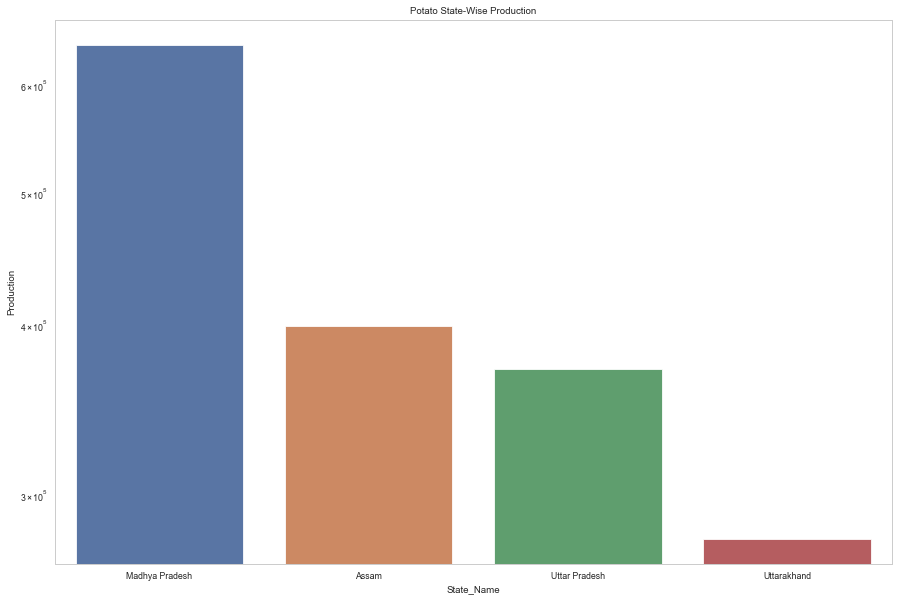

In [29]:
df = potato_df.groupby(by='State_Name')['Production'].sum().reset_index().sort_values(by='Production', ascending=False)
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(df.State_Name.head(4), df.Production.head(4),errwidth=0)
plt.yscale('log')
plt.title('Potato State-Wise Production')

And Indeed we do. Lets look at the agricultural area distribution within Uttar Pradesh

,District_Name,Crop,Area
9,LALITPUR,Potato,3622.0
12,SAHARANPUR,Potato,1992.0
11,PILIBHIT,Potato,1980.0
1,BANDA,Potato,1577.0
7,JALAUN,Potato,1426.0


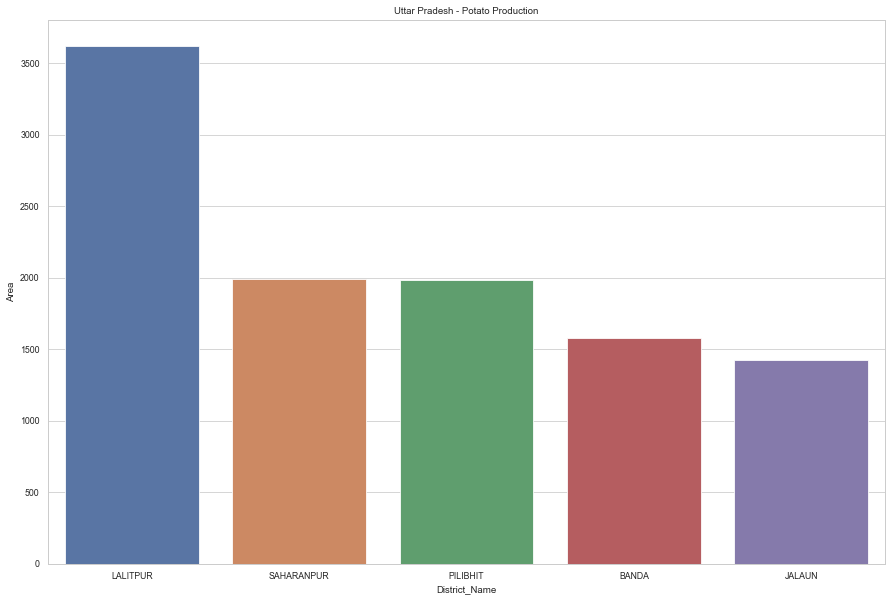

In [30]:
uttarpr_df = potato_df[(potato_df['State_Name'] == 'Uttar Pradesh')]
df = uttarpr_df.groupby(by=['District_Name', 'Crop'])['Area'].sum().reset_index().sort_values(by='Area', ascending=False)
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(df.District_Name.head(5), df.Area.head(5), errwidth=0)
plt.title('Uttar Pradesh - Potato Production')
df.head(5)

Agra, Kannauj and Firozabad have a combined area of 2,043,041 units for Potato. 

Now that we've explored the Seasons and Crops based on their production, the last thing I want to look at is agricultural area distribution all over India. From the above analysis we know, Uttar Pradesh is surely is going to top the list. Let's just check that out. 

### Agricultural Area

,State_Name,Area
30,Uttar Pradesh,7275418.0
16,Madhya Pradesh,6163529.0
14,Karnataka,5596175.0
17,Maharashtra,4595171.0
4,Bihar,3461615.0


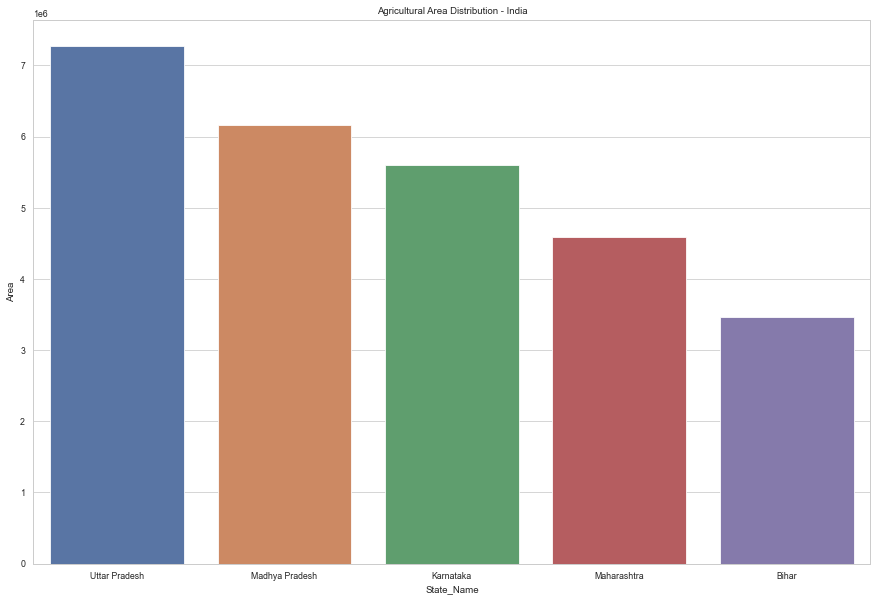

In [31]:
df = crop_df.groupby(by='State_Name')['Area'].sum().reset_index().sort_values(by='Area', ascending=False)
df.head()

fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(df.State_Name.head(5), df.Area.head(5), errwidth=0)
plt.title('Agricultural Area Distribution - India')
df.head(5)

And we proved it!

Let's look at the production of these five states over the years.

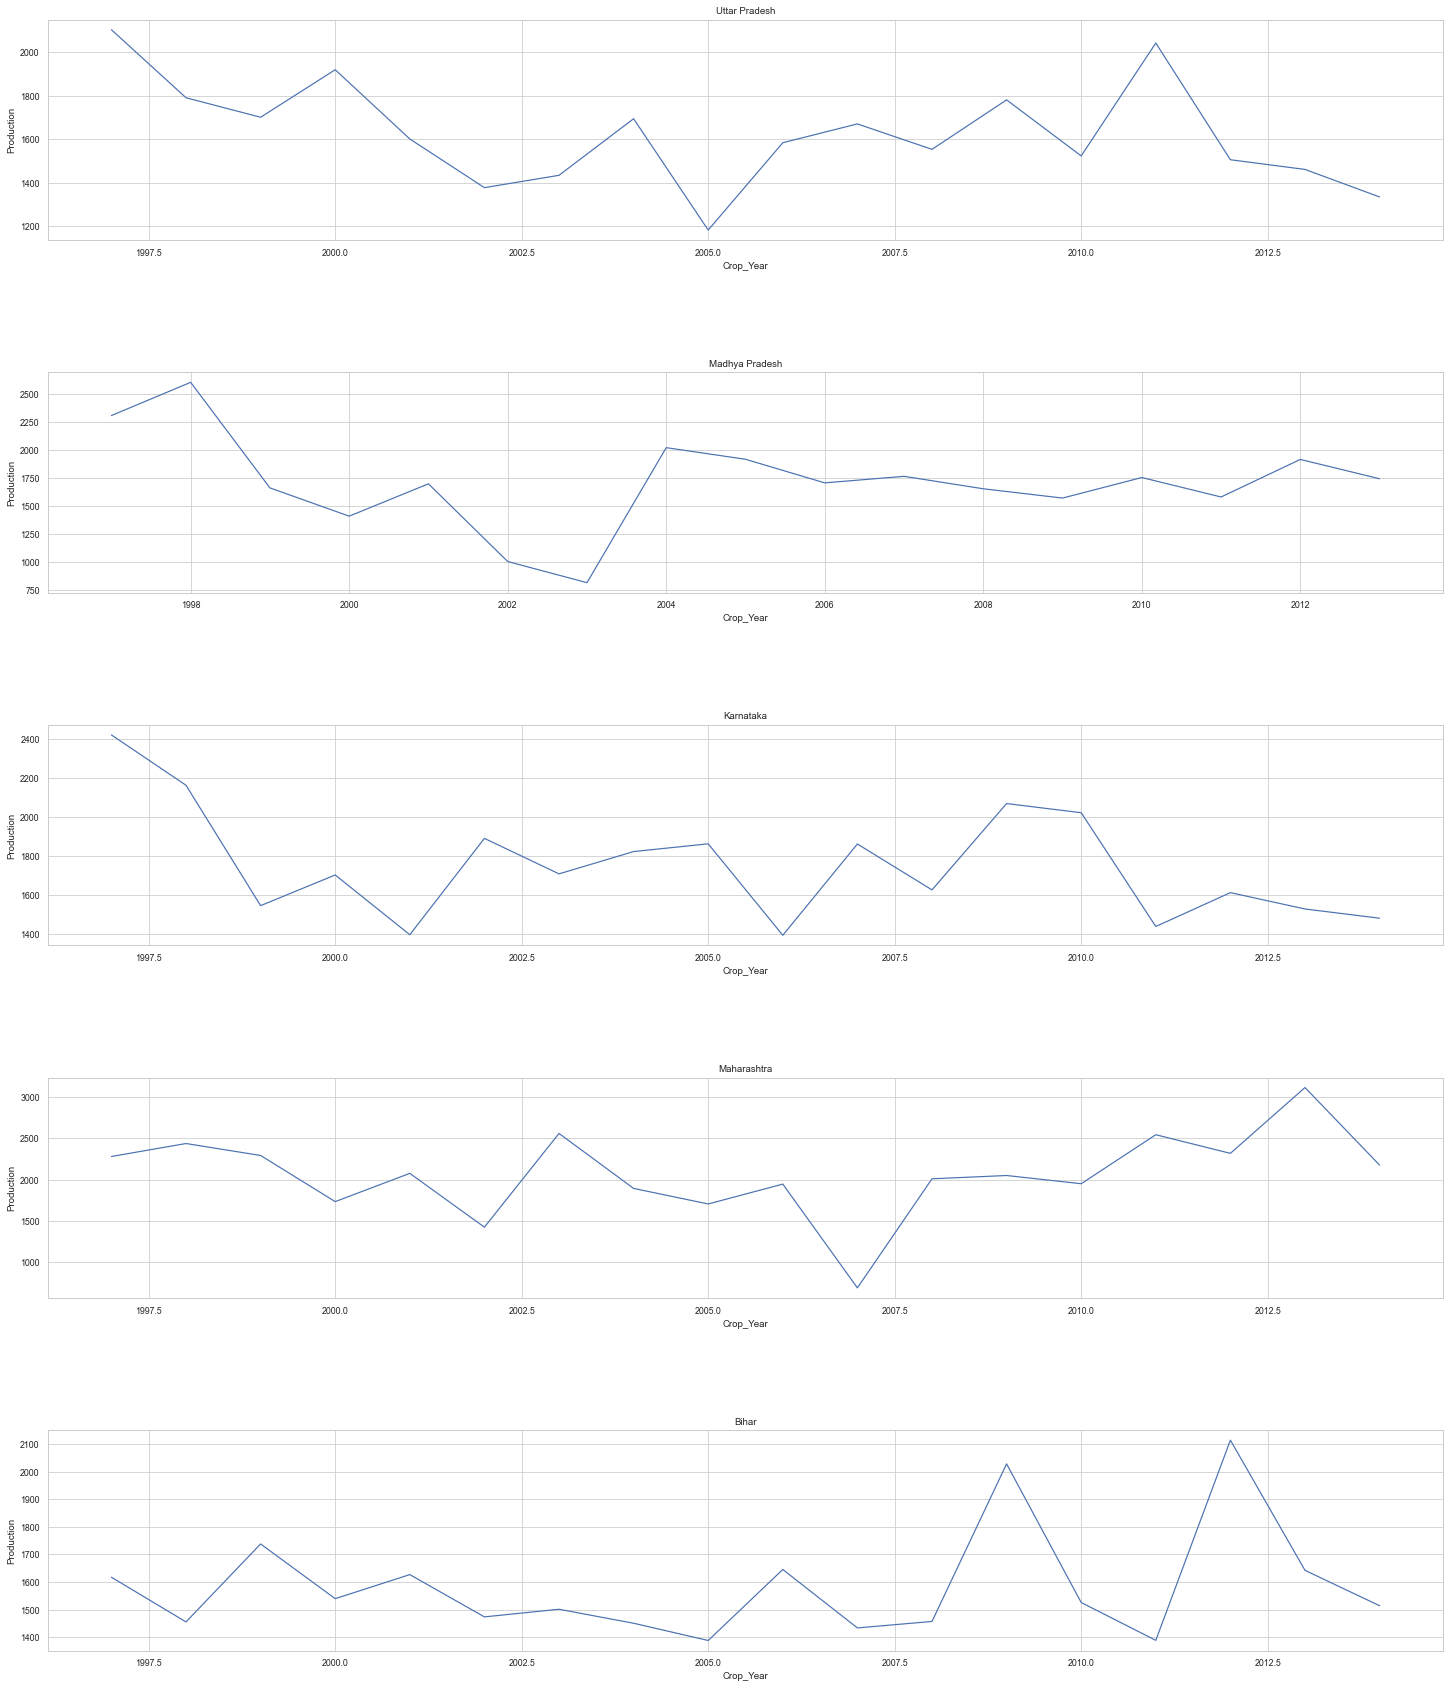

In [32]:
df = crop_df.groupby(by='State_Name')['Area'].sum().reset_index().sort_values(by='Area', ascending=False)
df = df.head(5)

fig, ax = plt.subplots(figsize=(25,30), sharey='col')
count = 1

for state in df.State_Name.unique():
    plt.subplot(len(df.State_Name.unique()),1,count)
    sns.lineplot(crop_df[crop_df.State_Name==state]['Crop_Year'],crop_df[crop_df.State_Name==state]['Production'], ci=None)
    plt.subplots_adjust(hspace=0.6)
    plt.title(state)
    count+=1

In [33]:
print(crop_df['Crop'].value_counts())

Maize                2143
Moong(Green Gram)    1846
Urad                 1817
Sesamum              1683
Groundnut            1504
                     ... 
other fibres            1
Litchi                  1
Atcanut (Raw)           1
Kapas                   1
Pear                    1
Name: Crop, Length: 120, dtype: int64


In [34]:
# Calculate the IQR for the Production and Area columns
Q1_prod = crop_df['Production'].quantile(0.25)
Q3_prod = crop_df['Production'].quantile(0.75)
IQR_prod = Q3_prod - Q1_prod

Q1_area = crop_df['Area'].quantile(0.25)
Q3_area = crop_df['Area'].quantile(0.75)
IQR_area = Q3_area - Q1_area

# Identify outliers by setting a threshold for the IQR (e.g., 1.5 times the IQR)
threshold = 1.5
prod_outliers = crop_df[(crop_df['Production'] < Q1_prod - threshold*IQR_prod) | 
                     (crop_df['Production'] > Q3_prod + threshold*IQR_prod)]

area_outliers = crop_df[(crop_df['Area'] < Q1_area - threshold*IQR_area) | 
                     (crop_df['Area'] > Q3_area + threshold*IQR_area)]

# Print the outliers
print("Production outliers:\n",prod_outliers)
print("Area outliers:\n", area_outliers)

Production outliers:
                State_Name District_Name  Crop_Year       Season  \
86424           Karnataka     DAVANGERE       2014  Summer        
207378      Uttar Pradesh    CHITRAKOOT       2003  Rabi          
233510        Uttarakhand      HARIDWAR       2000  Rabi          
10522   Arunachal Pradesh    EAST SIANG       2005  Whole Year    
60959             Gujarat       KACHCHH       2005  Rabi          
...                   ...           ...        ...          ...   
122010     Madhya Pradesh       SHEOPUR       2006  Kharif        
71846    Himachal Pradesh        CHAMBA       2006  Whole Year    
191602         Telangana       ADILABAD       2006  Rabi          
212848      Uttar Pradesh     GORAKHPUR       2000  Rabi          
54173        Chhattisgarh       RAIGARH       2003  Kharif        

                         Crop     Area  Production         Zones  \
86424               Groundnut   3215.0      4465.0    South Zone   
207378                 Barley   5841.

In [35]:
# Calculate the Z-score for each data point in the Production and Area columns
z_scores = np.abs((crop_df['Production'] - crop_df['Production'].mean()) / crop_df['Production'].std()) + \
           np.abs((crop_df['Area'] - crop_df['Area'].mean()) / crop_df['Area'].std())

# Identify outliers by setting a threshold for the Z-score (e.g., 3 standard deviations)
threshold = 3
outliers = crop_df[z_scores > threshold]

# Print the outliers
print(outliers)

            State_Name District_Name  Crop_Year       Season  \
207378   Uttar Pradesh    CHITRAKOOT       2003  Rabi          
233510     Uttarakhand      HARIDWAR       2000  Rabi          
60959          Gujarat       KACHCHH       2005  Rabi          
90922        Karnataka        KODAGU       2009  Whole Year    
111286  Madhya Pradesh        INDORE       2002  Whole Year    
...                ...           ...        ...          ...   
194857      Telangana       NALGONDA       2011  Kharif        
114577  Madhya Pradesh        MANDLA       2012  Rabi          
122010  Madhya Pradesh       SHEOPUR       2006  Kharif        
191602      Telangana       ADILABAD       2006  Rabi          
54173     Chhattisgarh       RAIGARH       2003  Kharif        

                     Crop     Area  Production         Zones  \
207378             Barley   5841.0      6735.0    North Zone   
233510             Potato    520.0     13000.0    North Zone   
60959   Rapeseed &Mustard   5700.0     

In [36]:
outliers.count()

State_Name             3396
District_Name          3396
Crop_Year              3396
Season                 3396
Crop                   3396
Area                   3396
Production             3396
Zones                  3396
Updated_Crop_Season    3396
dtype: int64

In [37]:
pd.set_option("display.max_rows", None)

In [38]:
print(crop_df['Crop'].value_counts())

Maize                        2143
Moong(Green Gram)            1846
Urad                         1817
Sesamum                      1683
Groundnut                    1504
Arhar/Tur                    1324
Onion                        1244
Dry chillies                 1240
Rapeseed &Mustard            1203
Gram                         1103
Rice                         1102
Sunflower                    1067
Jowar                        1026
Linseed                       933
Potato                        928
Small millets                 892
Peas & beans (Pulses)         864
Sweet potato                  827
Masoor                        799
Bajra                         775
Horse-gram                    767
Ragi                          761
Turmeric                      748
Barley                        747
Coriander                     690
Other Kharif pulses           666
Sugarcane                     648
Garlic                        613
Cotton(lint)                  610
Other  Rabi pu

In [39]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score

In [40]:
df = crop_df.drop(["District_Name","Crop_Year"],axis=1)

In [41]:
data_dum = pd.get_dummies(df)
data_dum.head(50)

,Area,Production,State_Name_Andaman and Nicobar Islands,State_Name_Andhra Pradesh,State_Name_Arunachal Pradesh,State_Name_Assam,State_Name_Bihar,State_Name_Chandigarh,State_Name_Chhattisgarh,State_Name_Dadra and Nagar Haveli,...,Zones_Central Zone,Zones_East Zone,Zones_NE Zone,Zones_North Zone,Zones_South Zone,Zones_Union Terr,Zones_West Zone,Updated_Crop_Season_Kharif,Updated_Crop_Season_Others,Updated_Crop_Season_Rabi
178662,114.0,69.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
22234,806.0,394.0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
139713,111.0,80.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
133998,300.0,300.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
220675,19.0,45.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
86424,3215.0,4465.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
14313,34.0,17.0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
149961,986.0,446.7,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
207378,5841.0,6735.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
96279,2528.0,3475.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [42]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler object on the 'Area' and 'Production' columns
scaler.fit(data_dum[['Area', 'Production']])

# Transform the 'Area' and 'Production' columns
data_dum[['Area', 'Production']] = scaler.transform(crop_df[['Area', 'Production']])


In [43]:
data_dum.head(50)

,Area,Production,State_Name_Andaman and Nicobar Islands,State_Name_Andhra Pradesh,State_Name_Arunachal Pradesh,State_Name_Assam,State_Name_Bihar,State_Name_Chandigarh,State_Name_Chhattisgarh,State_Name_Dadra and Nagar Haveli,...,Zones_Central Zone,Zones_East Zone,Zones_NE Zone,Zones_North Zone,Zones_South Zone,Zones_Union Terr,Zones_West Zone,Updated_Crop_Season_Kharif,Updated_Crop_Season_Others,Updated_Crop_Season_Rabi
178662,-0.500664,-0.539776,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
22234,-0.232680,-0.425498,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
139713,-0.501826,-0.535908,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
133998,-0.428634,-0.458551,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
220675,-0.537453,-0.548215,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
86424,0.700227,1.005958,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
14313,-0.531645,-0.558060,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
149961,-0.162974,-0.406968,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
207378,1.717170,1.804142,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
96279,0.434180,0.657852,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [44]:
data_dum.shape

(39084, 171)

In [45]:
x = data_dum.drop(["Production"], axis =1)
y = data_dum["Production"]

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [47]:
def optimal_k(k):
  modele = KNeighborsRegressor(n_neighbors=k)
  modele.fit(x_train, y_train)

  train_error = 1 - modele.score(x_train, y_train)
  val_error = 1 - modele.score(x_test, y_test)

  return {'Max Depth': k, 'Training Error': train_error, 'Validation Error': val_error}

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [52]:
from sklearn import svm

# Create a support vector regression model
model2 = svm.SVR()

model2.fit(x_train, y_train)

y_pred2 = model2.predict(x_test)

#print(y_pred2)

mse2 = mean_squared_error(y_test, y_pred2)
print("Mean squared error:", mse2) 

Mean squared error: 0.2424648659996357


In [53]:
from sklearn.metrics import r2_score


# Calculate the R-squared value
r2 = r2_score(y_test, y_pred2)

print(r2)  


0.7528724985191055


In [54]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest regression model with 10 trees
model = RandomForestRegressor(n_estimators=10)

# Train the model on the sample data
model.fit(x_train, y_train)

# Predict the target value for a new data point

y_pred3 = model.predict(x_test)

print(y_pred3)  


# Calculate the R-squared value
r2_3 = r2_score(y_test, y_pred3)

print("rsquared error:",r2_3)  
mse3 = mean_squared_error(y_test, y_pred3)
print("Mean squared error:", mse3)

[-0.132491    1.79419092 -0.44304425 ...  2.00449651 -0.52198357
 -0.5628773 ]
rsquared error: 0.7914359625058667
Mean squared error: 0.20462899151378985


from sklearn.model_selection import GridSearchCV

# Create a Random Forest regression model
model_best = RandomForestRegressor()

# Define the hyperparameters to search over
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [2, 5, None],
    'min_samples_split': [2, 5, 10]
}

# Perform a Grid Search to find the optimal hyperparameters
grid_search = GridSearchCV(model_best, param_grid=param_grid)
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding mean cross-validated score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


In [55]:
knn=KNeighborsRegressor()
dt=DecisionTreeRegressor()
gbm=GradientBoostingRegressor()
ada=AdaBoostRegressor()
xgb=XGBRegressor()
svr=svm.SVR()
rfr=RandomForestRegressor()

In [56]:
models=[]
models.append(('KNeighborsRegressor',knn))
models.append(('DecisionTreeRegressor',dt))
models.append(('GradientBoostingRegressor',gbm))
models.append(('AdaBoostRegressor',ada))
models.append(('XGBRegressor',xgb))
models.append(('RandomForestRegressor',rfr))

In [57]:
Model=[]
r2score=[]
rmse=[]
cv=[]

for name,model in models:
    print('*****************',name,'*******************')
    print('\n')
    Model.append(name)
    model.fit(x_train,y_train)
    print(model)
    pre=model.predict(x_test)
    print('\n')
    score=r2_score(y_test,pre)
    print('R2score  -',score)
    r2score.append(score*100)
    print('\n')
    sc=cross_val_score(model,x,y,cv=5,scoring='r2').mean()
    print('cross_val_score  -',sc)
    cv.append(sc*100)
    print('\n')
    rmsescore=np.sqrt(mean_squared_error(y_test,pre))
    print('rmse_score  -',rmsescore)
    rmse.append(rmsescore)
    print('\n')


***************** KNeighborsRegressor *******************


KNeighborsRegressor()


R2score  - 0.7812219918975355


cross_val_score  - 0.798707192896798


rmse_score  - 0.4633036280826505


***************** DecisionTreeRegressor *******************


DecisionTreeRegressor()


R2score  - 0.6944768289832453


cross_val_score  - 0.7130493551426186


rmse_score  - 0.5475022970904502


***************** GradientBoostingRegressor *******************


GradientBoostingRegressor()


R2score  - 0.6914720897806824


cross_val_score  - 0.7025948323458837


rmse_score  - 0.5501879798065208


***************** AdaBoostRegressor *******************


AdaBoostRegressor()


R2score  - 0.07215179327464061


cross_val_score  - -0.005281454413029763


rmse_score  - 0.9541185412865548


***************** XGBRegressor *******************


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stoppi

In [58]:
result=pd.DataFrame({'Model':Model,'R2_score':r2score,'RMSEscore':rmse,'Cross_val_score':cv})
result

,Model,R2_score,RMSEscore,Cross_val_score
0,KNeighborsRegressor,78.122199,0.463304,79.870719
1,DecisionTreeRegressor,69.447683,0.547502,71.304936
2,GradientBoostingRegressor,69.147209,0.550188,70.259483
3,AdaBoostRegressor,7.215179,0.954119,-0.528145
4,XGBRegressor,81.328082,0.428014,82.448259
5,RandomForestRegressor,80.664227,0.435557,81.739509
